In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
from scipy.ndimage import rotate, zoom
from sklearn.preprocessing import PowerTransformer
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from keras import models, layers, losses, optimizers, Model
from keras.utils import plot_model

2023-11-05 15:57:17.658870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 15:57:17.658901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 15:57:17.658936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gc.collect()

0

In [3]:
def pickle_pi_set(pi):
    pi_set = []
    mat_i = loadmat(f"mats/data-science-P{pi+1}.mat")
    coord_to_col = mat_i["meta"][0][0][8]
    data = mat_i["data"]
    info = mat_i["info"][0]

    yeojohnTr = PowerTransformer(standardize=True)
    
    for i in tqdm(range(359), desc=str(pi)):
        datum = data[i][0][0]

        scan = np.zeros((23, 61, 51))
        for x in range(51):
            for y in range(61):
                for z in range(23):
                    scan[z, y, x] = datum[coord_to_col[x, y, z] - 1]


        mask = scan != mode(scan.flat).mode

        scan[mask] = yeojohnTr.fit_transform(scan[mask].reshape((-1, 1))).reshape((-1, ))

        scan[mask] -= scan[mask].mean()
        scan[mask] /= scan[mask].std()

        n = 3
        mask_std = scan[mask].std()
        scan[scan > n * mask_std] = n * mask_std
        scan[scan < -n * mask_std] = -n * mask_std
        scan[scan == mode(scan.flat).mode] = scan[mask].min()

        scan[scan < 0] /= abs(scan.min())
        scan[scan > 0] /= scan.max()
        pi_set.append((scan, info[i][2][0]))

    with open(f"pickles/{pi}.pkl", "wb") as f:
        pickle.dump(pi_set, f)
    
        

In [4]:
def pickle_set():
    if not os.path.exists("pickles"):
        os.mkdir("pickles")
    Pool(processes=5).map(pickle_pi_set, range(9))

# pickle_set()

In [5]:
def get_feature_vectors():
    with open("feature_vecs.txt", "r") as f:
        f = f.read().split("\n\n\n")
        noun_dict = {}
        for noun_vec in f:
            split = noun_vec.split("\n\n")
            noun = split[0].split()[2][:-1]
            
            vec = split[1]
            vec = [item.strip().replace("(", "").replace(")", "") for item in vec.split(",\n")]
            vec = [(item.split()[:-1], item.split()[-1]) for item in vec]

            vec = sorted(vec, key=lambda x: x[0])
            vec = {" ".join(item[0]): float(item[1]) for item in vec}

            noun_dict[noun] = vec

    return noun_dict

feature_vectors = get_feature_vectors()

In [6]:
NUM_CLASSES = 60

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(9)]
targets = set([pickles[0][i][1] for i in range(len(pickles[0]))])

targets = list(targets)[:NUM_CLASSES]
targets = {k: [feature_vectors[k][k1] for k1 in feature_vectors[k]] for k in targets}

pickles = [item for sublist in pickles for item in sublist if item[1] in targets]
print(len(pickles), targets)

split = int(0.8 * len(pickles))
trains, tests = pickles[:split], pickles[split:]

train_x = np.array([train[0] for train in trains])
train_y = np.array([train[1] for train in trains])

test_x = [test[0] for test in tests]
test_y = [test[1] for test in tests]

del pickles, trains, tests

3231 {'door': [0.008, 0.012, 0.003, 0.015, 0.001, 0.036, 0.001, 0.002, 0.027, 0.008, 0.003, 0.0, 0.017, 0.031, 0.996, 0.024, 0.001, 0.0, 0.027, 0.037, 0.029, 0.0, 0.0, 0.003, 0.001], 'saw': [0.019, 0.023, 0.005, 0.032, 0.008, 0.031, 0.019, 0.009, 0.219, 0.018, 0.003, 0.0, 0.052, 0.028, 0.131, 0.004, 0.014, 0.0, 0.064, 0.934, 0.226, 0.004, 0.002, 0.011, 0.006], 'beetle': [0.0, 0.014, 0.063, 0.702, 0.487, 0.025, 0.0, 0.011, 0.014, 0.016, 0.0, 0.0, 0.064, 0.013, 0.203, 0.011, 0.063, 0.0, 0.06, 0.379, 0.256, 0.0, 0.0, 0.0, 0.045], 'table': [0.015, 0.012, 0.011, 0.009, 0.017, 0.02, 0.001, 0.033, 0.003, 0.025, 0.002, 0.001, 0.044, 0.032, 0.087, 0.008, 0.002, 0.001, 0.022, 0.046, 0.992, 0.0, 0.002, 0.01, 0.004], 'celery': [0.0, 0.0, 0.115, 0.0, 0.837, 0.0, 0.0, 0.315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.016, 0.243, 0.059, 0.346, 0.029, 0.0], 'desk': [0.054, 0.014, 0.187, 0.022, 0.038, 0.015, 0.001, 0.029, 0.012, 0.078, 0.014, 0.0, 0.115, 0.193, 0.862, 0.024, 0.033, 0.002

In [7]:
def get_sample(i, train=True):
    i = random.randint(0, len(train_x) - 1)

    x, y = ((train_x, train_y) if train else (test_x, test_y))
    scan, target = x[i], y[i]
    scan = np.pad(scan, ((0, 0), (2, 1), (7, 6)), constant_values=scan.min())
    
    # scan = rotate(scan, random.randint(-5, 5), axes=(0, 1), order=0, reshape=False, mode="constant", cval=-1, prefilter=False)
    # scan = rotate(scan, random.randint(-5, 5), axes=(1, 2), order=0, reshape=False, mode="constant", cval=-1, prefilter=False)
    # scan = rotate(scan, random.randint(-5, 5), axes=(2, 0), order=0, reshape=False, mode="constant", cval=-1, prefilter=False)

    scan = np.expand_dims(scan, -1)
    
    target = targets[target]

    return scan, target

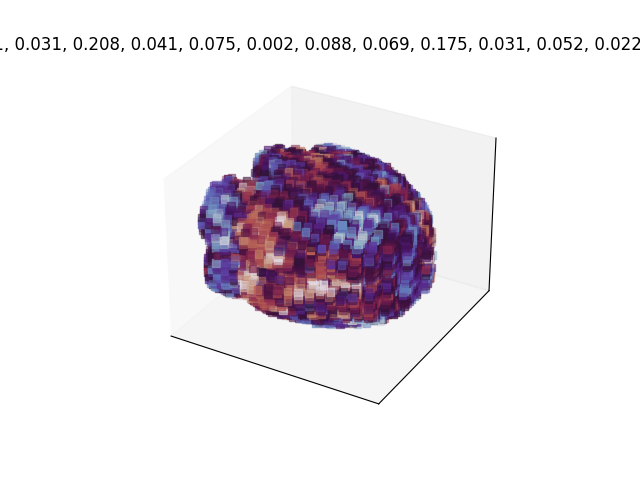

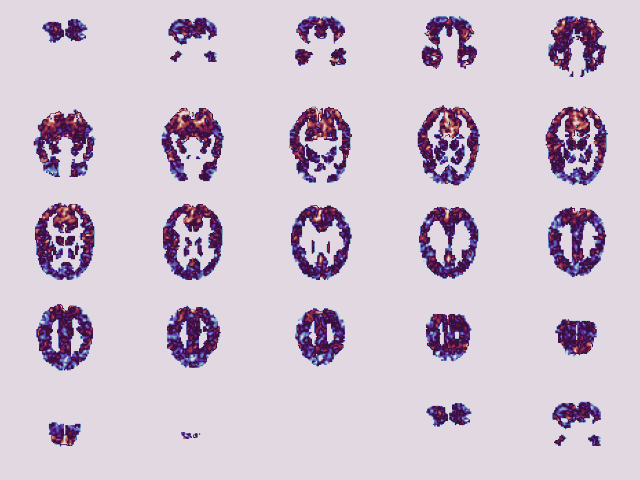

In [8]:
%matplotlib widget

def plot_scan(scan):
    scan, target = scan
    scan = (scan - scan.min()) / (scan.max() - scan.min())
    
    voxels = scan[scan != scan.min()]
    indices = np.where(scan != scan.min())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xticks([]) or ax.set_yticks([]) or ax.set_zticks([])
    ax.set_title(target)
    ax.scatter(indices[0], indices[1], indices[2], c=voxels, alpha=voxels, cmap="twilight", s=30, marker="s")
    plt.setp(ax.spines.values(), color=(1, 1, 1))
    plt.show()

    w = 5
    fig, ax = plt.subplots(w, w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan[j % scan.shape[0]], vmin=0, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

    plt.show()

plot_scan(get_sample(1))

In [9]:
def get_batch(batch_size=32, train=True):
    
    samples = list(Pool(processes=8).imap(get_sample, zip(range(batch_size), [train] * batch_size)))
    batch_x = [sample[0] for sample in samples]
    batch_y = [sample[1] for sample in samples]

    return np.array(batch_x), np.array(batch_y)

In [10]:
def layer_conv():
    return models.Sequential([
        layers.Input((64, 64 ,1)),
        layers.Conv2D(8, 16, 1, activation="tanh"),
        layers.Conv2D(8, 8, 1, activation="tanh"),
        layers.Conv2D(8, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(32, 4, 1, activation="tanh"),
        layers.Conv2D(32, 2, 1, activation="tanh"),
        layers.Conv2D(64, 2, 1, activation="tanh"),
        layers.Conv2D(128, 2, 1, activation="tanh"),
        layers.Flatten()
    ])

class LayerwiseConv(Model):
    def __init__(self):
        super().__init__()
        self.convs = [layer_conv() for _ in range(23)]
        self.dense = models.Sequential([
            layers.Dense(512, activation="tanh"),
            layers.Dense(256, activation="tanh"),
            layers.Dense(128, activation="tanh"),
            layers.Dense(25, activation="tanh"),
        ])

    @tf.function(reduce_retracing=True)
    def call(self, x):
        conv_outputs = []
        for j, conv in enumerate(self.convs):
            conv_outputs.append(conv(x[:, j]))

        x = tf.convert_to_tensor(conv_outputs)
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, (-1, tf.reduce_prod(x.shape[1:])))
        x = self.dense(x)

        return x

In [11]:
def conv3d_model():
    inputs = layers.Input((23, 64, 64, 1))
    x = layers.ZeroPadding3D(((5, 4), (0, 0), (0, 0)))(inputs)

    x = layers.Conv3D(8, 4, 1, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(8, 4, (1, 2, 2), padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(16, 4, 2, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(16, 4, 1, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(32, 4, 2, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(32, 4, 1, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(64, 4, 2, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(64, 4, 1, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(128, 4, 1, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv3D(128, 4, 2, padding="same", activation="tanh")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(25, activation="tanh")(x)

    return Model(inputs=inputs, outputs=x)

In [12]:
BATCH_SIZE = 64

model = conv3d_model()

opt = optimizers.Adam(learning_rate=0.0001)
loss = losses.CosineSimilarity()

def train():
    model.compile(opt, loss)

    for i in range(10000):
        with tf.GradientTape() as tape:
            batch_x, batch_y = get_batch(BATCH_SIZE)
            batch_x, batch_y = tf.convert_to_tensor(batch_x, dtype=tf.dtypes.float32), tf.convert_to_tensor(batch_y, dtype=tf.dtypes.float32)

            pred_y = model(batch_x)

            if i == 0:
                model.summary()

            batchloss = loss(batch_y, pred_y)
            grad = tape.gradient(batchloss, model.trainable_variables)
            opt.apply_gradients(zip(grad, model.trainable_variables))

            print(i, float(batchloss))

        if i % 100 == 0 and i != 0:
            batch_x, batch_y = get_batch(32, train=False)
            model.evaluate(batch_x, batch_y, batch_size=1)

        if i % 1000 == 0:
            model.save("model")

train()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23, 64, 64, 1)]   0         
                                                                 
 zero_padding3d (ZeroPaddin  (None, 32, 64, 64, 1)     0         
 g3D)                                                            
                                                                 
 conv3d (Conv3D)             (None, 32, 64, 64, 8)     520       
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 8)     4104      
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 16, 16, 16)    8208      
                                                                 
 conv3d_3 (Conv3D)           (None, 16, 16, 16, 16)    16400     
                                                             

INFO:tensorflow:Assets written to: model/assets


1 -0.469488263130188
2 -0.525784969329834
3 -0.6251201629638672
4 -0.6088137030601501
5 -0.5933414101600647
6 -0.6001670360565186
7 -0.5796031951904297
8 -0.6043561100959778
9 -0.6081722378730774
10 -0.6274928450584412
11 -0.6250972747802734
12 -0.609673023223877
13 -0.6486656665802002
14 -0.5985262393951416
15 -0.6379330158233643
16 -0.666466236114502
17 -0.6530942320823669
18 -0.6253988742828369
19 -0.6373440623283386
20 -0.6123437881469727
21 -0.592620849609375
22 -0.5849350690841675
23 -0.642731785774231
24 -0.6167857646942139
25 -0.6190047264099121
26 -0.6276777982711792
27 -0.6753169298171997
28 -0.6138280630111694
29 -0.6368041038513184
30 -0.6547199487686157
31 -0.6189805269241333
32 -0.6263411045074463
33 -0.6018006205558777
34 -0.66249018907547
35 -0.6093407869338989
36 -0.6368662118911743
37 -0.6193795204162598
38 -0.6390014290809631
39 -0.6541745662689209
40 -0.6582765579223633
41 -0.6643866300582886
42 -0.6279973983764648
43 -0.5933487415313721
44 -0.6152738332748413
45 -0

INFO:tensorflow:Assets written to: model/assets


1001 -0.7417234778404236
1002 -0.7398023009300232
1003 -0.7459855079650879
1004 -0.7850344181060791
1005 -0.721053957939148
1006 -0.7457963228225708
1007 -0.7345045208930969
1008 -0.7579718828201294
1009 -0.7417964935302734
1010 -0.7544097900390625
1011 -0.7382450103759766
1012 -0.7426231503486633
1013 -0.7031554579734802
1014 -0.710242509841919
1015 -0.731247067451477
1016 -0.7429628372192383
1017 -0.7233873605728149
1018 -0.7543508410453796
1019 -0.692415714263916
1020 -0.6928998827934265
1021 -0.7343149185180664
1022 -0.720404863357544
1023 -0.750759482383728
1024 -0.744224488735199
1025 -0.7388969659805298
1026 -0.7379922270774841
1027 -0.7240181565284729
1028 -0.734441876411438
1029 -0.7520251274108887
1030 -0.7212213277816772
1031 -0.7270369529724121
1032 -0.7470172643661499
1033 -0.736732542514801
1034 -0.7534791231155396
1035 -0.7409718632698059
1036 -0.7412782907485962
1037 -0.7411938905715942
1038 -0.7498730421066284
1039 -0.7274511456489563
1040 -0.7472031116485596
1041 -0.7

INFO:tensorflow:Assets written to: model/assets


2001 -0.7998545169830322
2002 -0.801060676574707
2003 -0.7986800670623779
2004 -0.7864409685134888
2005 -0.7897363901138306
2006 -0.8158989548683167
2007 -0.7902885675430298
2008 -0.8248833417892456
2009 -0.7761739492416382
2010 -0.7870539426803589
2011 -0.8229069709777832
2012 -0.7873659133911133
2013 -0.8029710054397583
2014 -0.7837373614311218
2015 -0.7931587100028992
2016 -0.8009157776832581
2017 -0.7854663729667664
2018 -0.7999591827392578
2019 -0.8046799898147583
2020 -0.802865743637085
2021 -0.7916125059127808
2022 -0.7977572679519653
2023 -0.8171188831329346
2024 -0.8055770397186279
2025 -0.8053575754165649
2026 -0.8099180459976196
2027 -0.8044042587280273
2028 -0.8130707740783691
2029 -0.8086659908294678
2030 -0.7975992560386658
2031 -0.8265436887741089
2032 -0.8208789229393005
2033 -0.7759202122688293
2034 -0.8017104268074036
2035 -0.805635929107666
2036 -0.795215368270874
2037 -0.8043801784515381
2038 -0.7884383201599121
2039 -0.782180666923523
2040 -0.807379961013794
2041 -

INFO:tensorflow:Assets written to: model/assets


3001 -0.8298810720443726
3002 -0.8227563500404358
3003 -0.8370709419250488
3004 -0.8205273151397705
3005 -0.8165797591209412
3006 -0.8478583693504333
3007 -0.8372873067855835
3008 -0.8363243341445923
3009 -0.8441551327705383
3010 -0.8425168991088867
3011 -0.8259074687957764
3012 -0.8234614729881287
3013 -0.8172951340675354
3014 -0.8378826975822449
3015 -0.8123708367347717
3016 -0.8222143650054932
3017 -0.8328572511672974
3018 -0.8234919309616089
3019 -0.8109394907951355
3020 -0.8483065366744995
3021 -0.8289672136306763
3022 -0.8274902105331421
3023 -0.8358980417251587
3024 -0.8403836488723755
3025 -0.8292896747589111
3026 -0.8125754594802856
3027 -0.8368499279022217
3028 -0.8309742212295532
3029 -0.8385621905326843
3030 -0.8250923752784729
3031 -0.8324110507965088
3032 -0.833465039730072
3033 -0.8262507319450378
3034 -0.8176712393760681
3035 -0.8569498658180237
3036 -0.8127244710922241
3037 -0.8244397044181824
3038 -0.8208643794059753
3039 -0.8104087114334106
3040 -0.8311778903007507
3